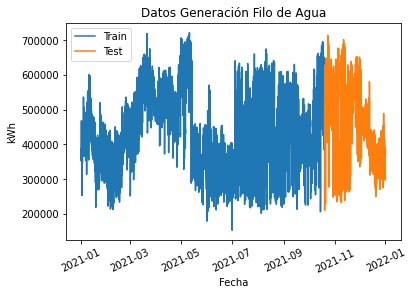

In [22]:
# Parte 1 - Preprocesado de los datos

# Importación de las librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importar el dataset
df = pd.read_csv("DataGeneración_filo.csv")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.set_index("Fecha", inplace=True)

dataset_train = df.iloc[:7008,0].copy()  # 80%
training_set = dataset_train.values.reshape(-1,1)

dataset_test = df.iloc[7008:,0].copy()  # 20%
real = dataset_test.values.reshape(-1,1)

plt.title("Datos Generación Filo de Agua")
plt.ylabel("kWh")
plt.xlabel("Fecha")
plt.plot(df.index[:7008], dataset_train.values, label="Train")
plt.plot(df.index[7008:], dataset_test.values, label="Test")
plt.legend()
plt.xticks(rotation=25)
plt.show()

In [23]:
# Escalado de características
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Crear una estructura de datos con 60 timesteps y 1 salida
X_train = []
y_train = []
for i in range(60, 7008):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Redimensión de los datos
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [24]:
# Parte 2 - Construcción de la RNR
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Inicialización del modelo
regressor = Sequential()

# Añadir la primera capa de LSTM y la regulariación por Dropout
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1) ))
regressor.add(Dropout(0.2))

# Añadir la segunda capa de LSTM y la regulariación por Dropout
regressor.add(LSTM(units = 50, return_sequences = True ))
regressor.add(Dropout(0.2))

# Añadir la tercera capa de LSTM y la regulariación por Dropout
regressor.add(LSTM(units = 50, return_sequences = True ))
regressor.add(Dropout(0.2))

# Añadir la cuarta capa de LSTM y la regulariación por Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Añadir la capa de salida
regressor.add(Dense(units = 1))

# Compilar la RNR
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Ajustar la RNR al conjunto de entrenamiento
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
218/218 [==============================] - 32s 97ms/step - loss: 0.0325
Epoch 2/100
218/218 [==============================] - 21s 97ms/step - loss: 0.0219
Epoch 3/100
218/218 [==============================] - 22s 100ms/step - loss: 0.0174
Epoch 4/100
218/218 [==============================] - 20s 93ms/step - loss: 0.0166
Epoch 5/100
218/218 [==============================] - 22s 99ms/step - loss: 0.0152
Epoch 6/100
218/218 [==============================] - 20s 93ms/step - loss: 0.0143
Epoch 7/100
218/218 [==============================] - 21s 97ms/step - loss: 0.0131
Epoch 8/100
218/218 [==============================] - 20s 94ms/step - loss: 0.0127
Epoch 9/100
218/218 [==============================] - 20s 92ms/step - loss: 0.0114
Epoch 10/100
218/218 [==============================] - 20s 94ms/step - loss: 0.0103
Epoch 11/100
218/218 [==============================] - 23s 105ms/step - loss: 0.0095
Epoch 12/100
218/218 [==============================] - 20s 92ms/step - 

In [25]:
# Descripción de la LSTM
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)               

In [26]:
# Parte 3 - Ajustar las predicciones
# Obtener la predicción con la RNR
dataset_total = pd.concat((dataset_train, dataset_test))
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 1752):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

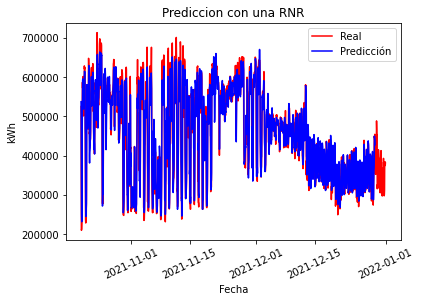

In [27]:
# Visualizar los Resultados
plt.plot(df.index[7008:], real, color = 'red', label = 'Real')
plt.plot(df.index[7008:-60], predicted, color = 'blue', label = 'Predicción')
plt.title("Prediccion con una RNR")
plt.xlabel("Fecha")
plt.ylabel("kWh")
plt.xticks(rotation=25)
plt.legend()
plt.show()

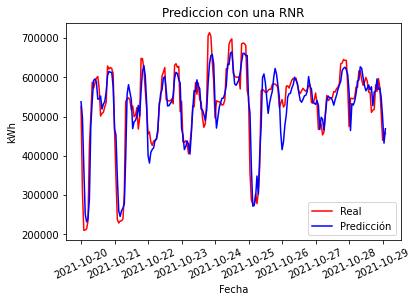

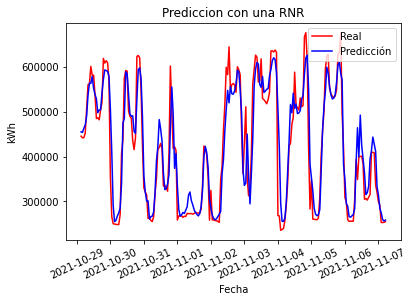

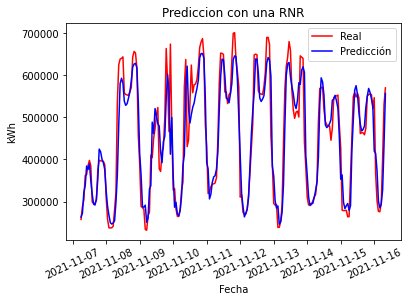

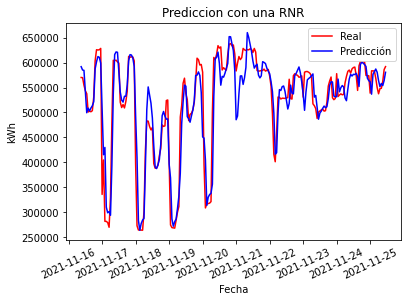

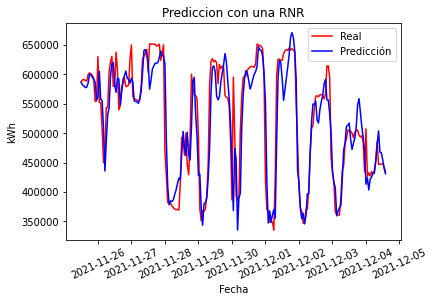

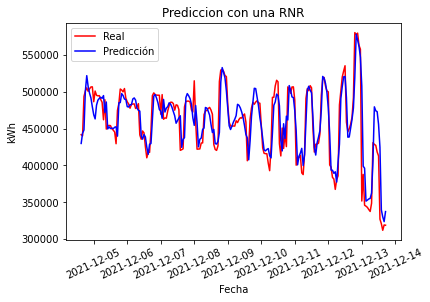

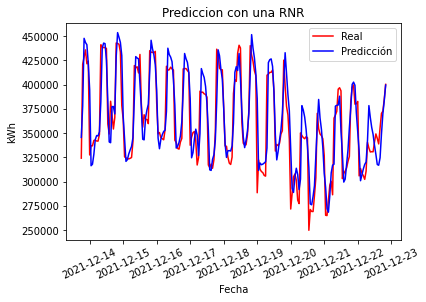

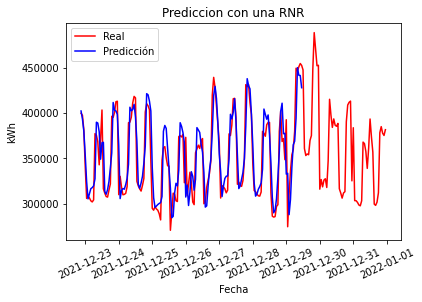

In [58]:
for i in range(1,9):
    plt.plot(df.index[7008+219*(i-1):7008+219*i], real[219*(i-1):219*i], color = 'red', label = 'Real')
    if i == 8:
        plt.plot(df.index[7008+219*(i-1):7008-60+219*i], predicted[219*(i-1):219*i], color = 'blue', label = 'Predicción')
    else:
        plt.plot(df.index[7008+219*(i-1):7008+219*i], predicted[219*(i-1):219*i], color = 'blue', label = 'Predicción')
    plt.title("Prediccion con una RNR")
    plt.xlabel("Fecha")
    plt.ylabel("kWh")
    plt.xticks(rotation=25)
    plt.legend()
    plt.show()